In [1]:
# ✅ STEP 1: Install required libraries
!pip install diffusers transformers accelerate evaluate scikit-image matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 844.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install medmnist scikit-image matplotlib torchvision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 480.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install kornia --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.2 MB/s eta 0:00:00


100%|██████████| 206M/206M [00:08<00:00, 23.1MB/s]


Epoch 1, Loss: 0.0164
Epoch 2, Loss: 0.0130
Epoch 3, Loss: 0.0127
Epoch 4, Loss: 0.0126
Epoch 5, Loss: 0.0125
Epoch 6, Loss: 0.0125
Epoch 7, Loss: 0.0124
Epoch 8, Loss: 0.0124
Epoch 9, Loss: 0.0123
Epoch 10, Loss: 0.0123
PSNR: 35.40, SSIM: 0.9220


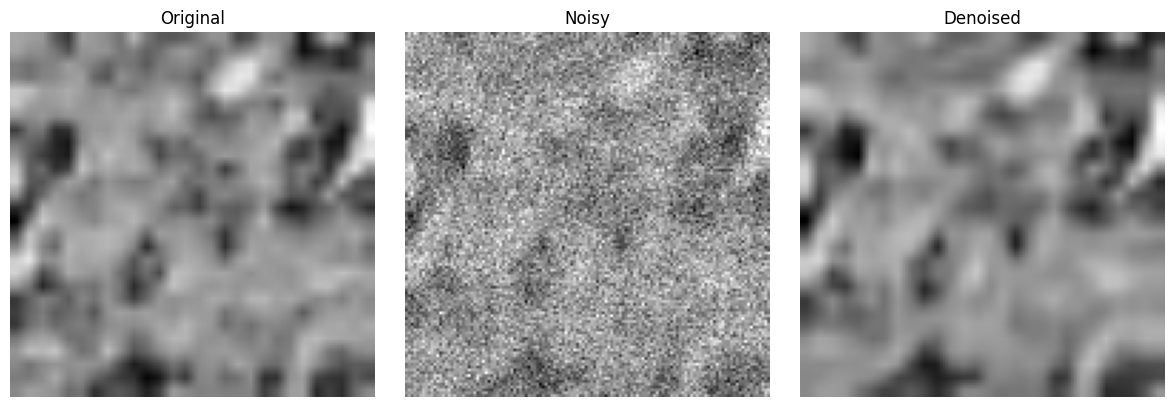

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from medmnist import PathMNIST

# ✅ STEP 3: Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ STEP 4: Load MedMNIST and create noisy-clean pairs
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

raw_dataset = PathMNIST(split='train', download=True, transform=transform)

class NoisyDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # img: [3, H, W]
        img_gray = img.mean(dim=0, keepdim=True)  # [1, H, W] grayscale
        clean = img_gray.clamp(0, 1)
        noisy = random_noise(clean.numpy(), mode='gaussian', var=0.01)
        noisy = torch.tensor(noisy).float()
        return noisy, clean

# ✅ STEP 5: DataLoader
dataset = NoisyDataset(raw_dataset)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# ✅ STEP 6: Define U-Net for denoising
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.down1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.middle = conv_block(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_block2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_block1 = conv_block(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        x5 = self.middle(x4)
        x6 = self.up2(x5)
        x6 = torch.cat([x3, x6], dim=1)
        x7 = self.up_block2(x6)
        x8 = self.up1(x7)
        x8 = torch.cat([x1, x8], dim=1)
        x9 = self.up_block1(x8)
        return self.out(x9)

model = UNet().to(device)

# ✅ STEP 7: Define SSIM loss and TV loss
import kornia.losses as kloss

# SSIM Loss using Kornia (supports batches, avoids skimage limitation)
ssim_loss_fn = kloss.SSIMLoss(window_size=7, reduction='mean')

def tv_loss(x):
    return torch.mean(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + \
           torch.mean(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))

mse_loss = nn.MSELoss()

# ✅ STEP 8: Train U-Net
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
for epoch in range(10):
    total_loss = 0
    for noisy, clean in dataloader:
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(noisy)
        ssim_val = ssim_loss_fn(output, clean)
        loss = mse_loss(output, clean) + 0.5 * ssim_val + 0.0001 * tv_loss(output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

# ✅ STEP 9: Evaluate on test image
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    noisy, clean = next(iter(test_loader))
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    denoised = output.squeeze().cpu().numpy()
    clean = clean.squeeze().cpu().numpy()
    noisy = noisy.squeeze().cpu().numpy()

# ✅ STEP 10: Metrics
psnr = peak_signal_noise_ratio(clean, denoised, data_range=1.0)
ssim_val = structural_similarity(clean, denoised, data_range=1.0)
print(f"PSNR: {psnr:.2f}, SSIM: {ssim_val:.4f}")

# ✅ STEP 11: Visualization
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(clean, cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(noisy, cmap='gray'); axs[1].set_title("Noisy")
axs[2].imshow(denoised, cmap='gray'); axs[2].set_title("Denoised")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

In [9]:
from PIL import Image
import numpy as np
from skimage.util import random_noise
from skimage.transform import resize
import torch
import matplotlib.pyplot as plt

# ✅ Step 1: Load the image
image_path = "/content/brain2.jpg"  # ← Replace with your image path
img = Image.open(image_path).convert("L")   # Convert to grayscale

# ✅ Step 2: Resize and normalize to [0, 1]
img_resized = resize(np.array(img), (128, 128), anti_aliasing=True)
img_normalized = img_resized / 255.0 if img_resized.max() > 1 else img_resized

# ✅ Step 3: Add synthetic noise
noisy_img = random_noise(img_normalized, mode='gaussian', var=0.01)

# ✅ Step 4: Convert to torch tensors
clean_tensor = torch.tensor(img_normalized).unsqueeze(0).unsqueeze(0).float().to(device)
noisy_tensor = torch.tensor(noisy_img).unsqueeze(0).unsqueeze(0).float().to(device)


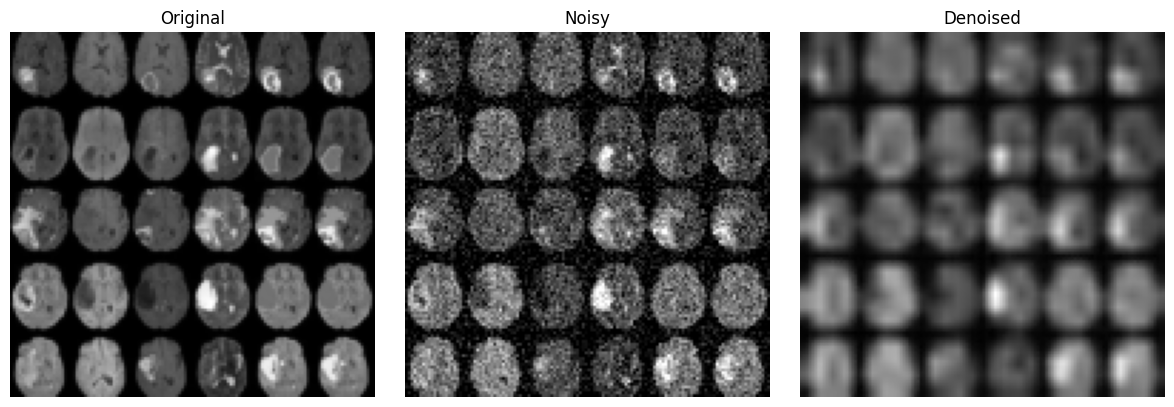

In [10]:
model.eval()
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)
    denoised_img = denoised_tensor.squeeze().cpu().numpy()

# ✅ Visualization
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_normalized, cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(noisy_img, cmap='gray'); axs[1].set_title("Noisy")
axs[2].imshow(denoised_img, cmap='gray'); axs[2].set_title("Denoised")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

